In [1]:
from sdv.tabular import GaussianCopula

from sklearn.datasets import load_iris


# 変数定義
field_transformers = {
    'sepal length (cm)': 'float',
    'sepal width (cm)': 'float',
    'petal length (cm)': 'float',
    'petal width (cm)': 'float',
    'target': 'categorical'
}
gc = GaussianCopula(field_transformers=field_transformers)

In [2]:
# irisデータセットをロード
iris = load_iris()
# 特徴量
data = iris.get('data')
# ターゲット変数
target = iris.get('target')

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4956: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


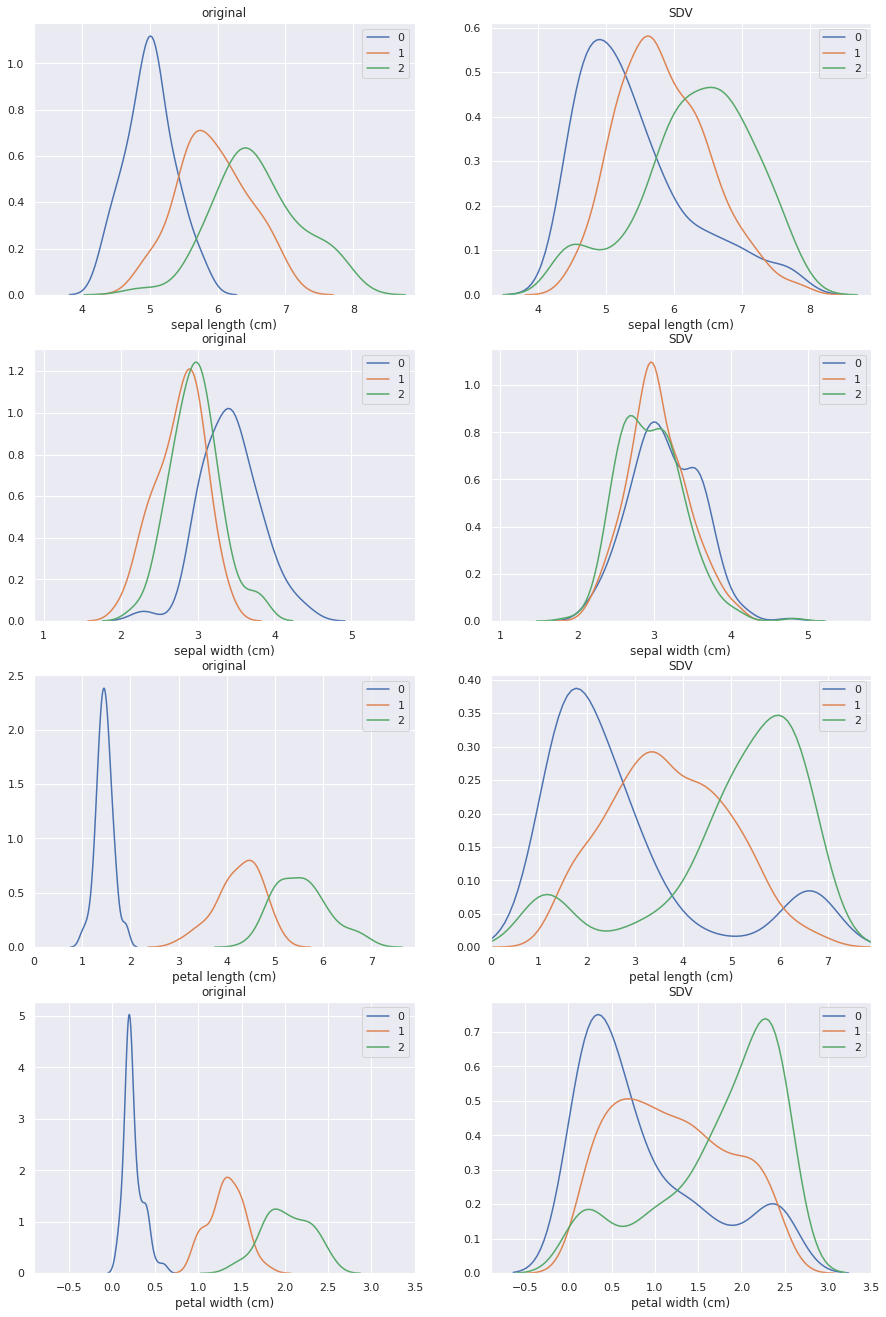

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import numpy as np

import pandas as pd


# 特徴量とターゲット変数をまとめてDataFrameに変換
data_tmp = pd.concat([pd.DataFrame(data, columns=iris.get('feature_names')), pd.DataFrame(target, columns=['target'])], axis=1)
# GaussianCopulaでモデリング
gc.fit(data_tmp)

# 合成するデータ数
N = 1000
# GaussianCopulaからデータを合成
sampled = gc.sample(N)

fig = plt.figure(figsize=(15,23))
# 特徴量ごとに軸を固定
max_xlims = [np.max([data_tmp[i].max(), sampled[i].max()]) for i in iris.get('feature_names')]
min_xlims = [np.min([data_tmp[i].min(), sampled[i].min()]) for i in iris.get('feature_names')]

for num, (j, max_xlim, min_xlim) in enumerate(zip(iris.get('feature_names'), max_xlims, min_xlims)):
    ax1 = fig.add_subplot(4, 2, num*2+1)
    for i, v in data_tmp.groupby('target'):
        sns.distplot(v[j], label=str(i), ax=ax1, hist=False)
        ax1.set_xlim(min_xlim - 1.0, max_xlim + 1.0)
        ax1.set_title('original')
    ax2 = fig.add_subplot(4, 2, num*2+2)
    for i, v in sampled.groupby('target'):
        sns.distplot(v[j], label=str(i), ax=ax2, hist=False)
        ax2.set_xlim(min_xlim - 1.0, max_xlim + 1.0)
        ax2.set_title('SDV')

Text(0.5, 1.02, 'generated Data by SVD')

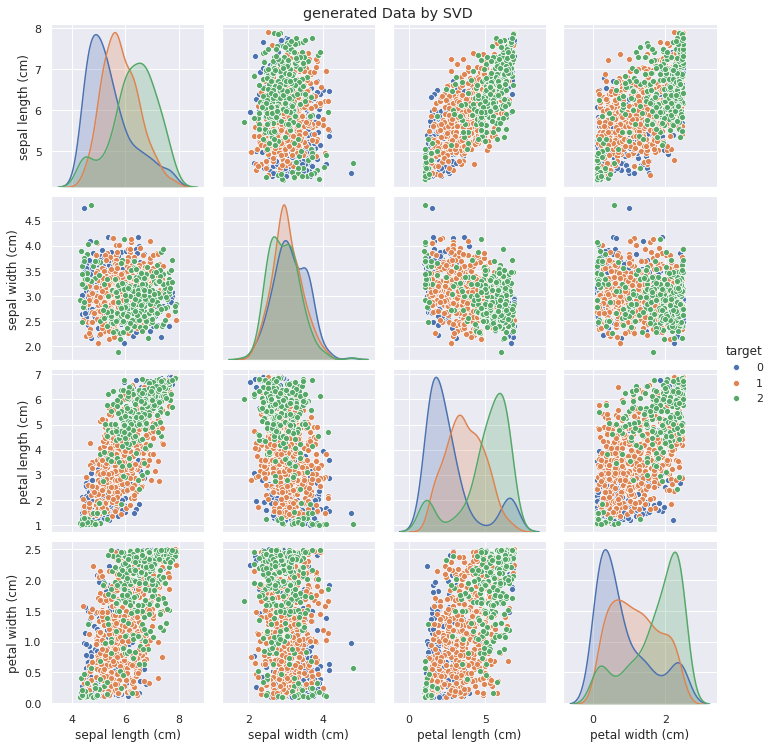

In [5]:
g = sns.pairplot(data=sampled, hue='target')
g.fig.suptitle('generated Data by SVD', y=1.02)

Text(0.5, 1.02, 'original Data')

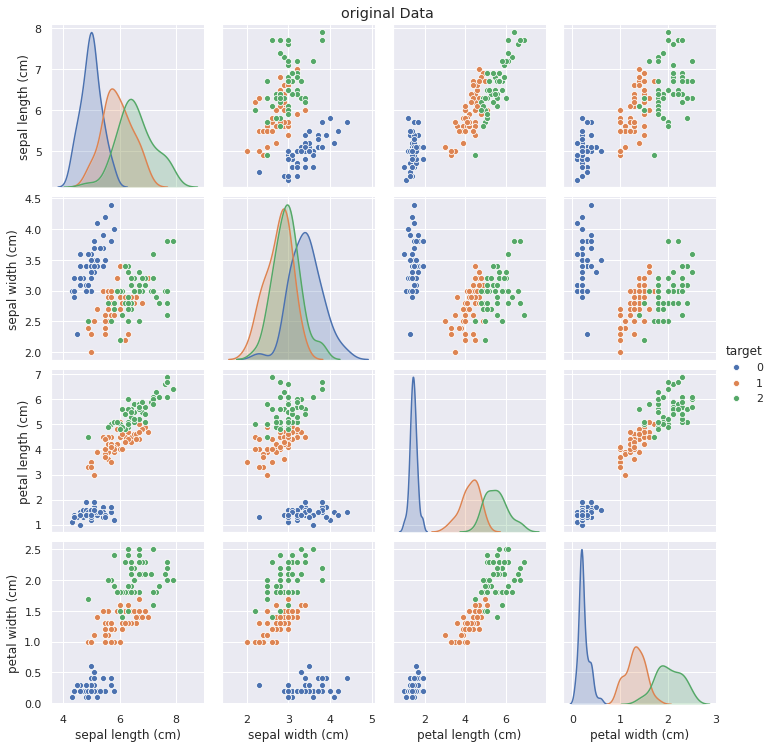

In [6]:
g = sns.pairplot(data=data_tmp, hue='target')
g.fig.suptitle('original Data', y=1.02)

In [7]:
# 層化5分割
skf = StratifiedKFold(n_splits=5, shuffle=True)
syn_scores = list()
origin_scores = list()

# ロジスティック回帰のパラメータグリッド
C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for train_idx, val_idx in skf.split(data, target):
    # 学習データ
    X_train, X_test = data[train_idx], data[val_idx]
    # テストデータ
    y_train, y_test = target[train_idx], target[val_idx]
    # 学習データの特徴量とターゲット変数を結合
    train_tmp = pd.concat([pd.DataFrame(X_train, columns=iris.get('feature_names')), pd.DataFrame(y_train, columns=['target'])], axis=1)
    # GaussianCopulaでモデリング
    gc.fit(train_tmp)
    # 学習データと同数をサンプリング
    sample_gc = gc.sample(len(train_tmp))
    syn_score = list()
    ori_score = list()
    for c in C:
        # 合成データに対するロジスティック回帰モデル構築
        lr_syn = LogisticRegression(C=c)
        lr_syn.fit(sample_gc[iris.get('feature_names')], sample_gc['target'])
        # オリジナルデータに対するロジスティック回帰モデル構築
        lr_ori = LogisticRegression(C=c)
        lr_ori.fit(X_train, y_train)
        syn_score.append(lr_syn.score(X_test, y_test))
        ori_score.append(lr_ori.score(X_test, y_test))

    syn_scores.append(syn_score)
    origin_scores.append(ori_score)

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4956: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

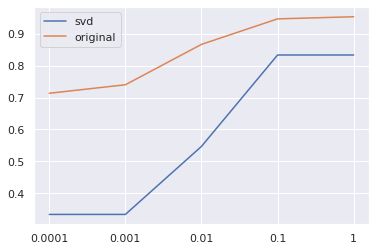

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([str(i) for i in C], np.mean(np.array(syn_scores), axis=0), label='svd')
ax.plot([str(i) for i in C], np.mean(np.array(origin_scores), axis=0), label='original')
ax.legend()